In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../..')

from app.core.audio.AudioData import AudioData
from app.core.audio.AudioPlayer import AudioPlayer
from app.core.midi.MidiData import MidiData
from app.core.midi.MidiPlayer import MidiPlayer
from app.core.midi.MidiSynth import MidiSynth

from app.algorithms.pitch.PYin import PYin
from app.algorithms.align.OnsetDf import UserOnsetDf, MidiOnsetDf
from app.config import AppConfig
from app.core.recording.PitchDf import PitchDf, PitchConfig
from app.algorithms.align.DTW import DTW

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
# AUDIO_FILEPATH = '../../app/resources/audio/rhythm_sally.mp3'
AUDIO_FILEPATH = '../../app/resources/audio/pitch_sally.mp3'
MIN_VIOLIN_FREQ = 196.0
SAMPLE_RATE = 44100

audio_data = AudioData()
audio_data.load_data(AUDIO_FILEPATH)
pitches, most_likely_pitches = PYin.pyin(audio_data.data)

Processing frame 7180/7180
Done!


In [4]:
audio_player = AudioPlayer()
audio_player.load_audio_data(audio_data)
audio_player.play()

In [5]:
# Create a synth with a soundfont
SOUNDFONT_FILEPATH = '../../app/resources/MuseScore_General.sf3'
midi_synth = MidiSynth(SOUNDFONT_FILEPATH)

# Load the midi file into a MidiData object
MIDI_FILEPATH = 'fugue_slower.mid'
midi_data = MidiData(MIDI_FILEPATH)

# Create MidiSynth/Player objects
midi_player = MidiPlayer(midi_synth)
midi_player.load_midi(midi_data)

# midi_player.play(start_time=0) # Play the MIDI

Loading MidiSynth...
Synth + soundfont loaded.


### Change tempo of MIDI
To help alignment, make the MIDI be the same duration as the user's audio

In [6]:
# audio_data.get_length()
midi_data.change_tempo(target_length=audio_data.get_length())
midi_data.save_to_file()
# temp_midi_file.data
midi_player.play(start_time=0) # Play the MIDI

In [5]:
midi_data.pitch_df

,start,channel,pitch,velocity,duration,frequency
0,0.000000,0,62,100,0.185938,293.664768
1,0.187500,0,69,100,0.185938,440.000000
2,0.375001,0,73,100,0.185938,554.365262
3,0.562501,0,76,100,0.185938,659.255114
4,0.750002,0,77,100,0.185938,698.456463
...,...,...,...,...,...,...
60,11.250030,0,63,100,0.185938,311.126984
61,11.437530,0,74,100,0.185938,587.329536
62,11.625031,0,79,100,0.185938,783.990872
63,11.812532,0,72,100,0.185938,523.251131


In [10]:
pitch_config = PitchConfig( # Defines resolution of pitch bins
    bins_per_semitone=10, tuning=440.0, fmin=196, fmax=5000
)
pitch_df = PitchDf(audio_data, pitch_config, pitches)
# pitch_df.df

In [7]:
pitch_df.best_prob_df()

,time,frequency,midi_num,probability,volume,audio_idx
0,0.000000,293.685203,62.001205,0.163487,0.020647,0
1,0.002902,294.031231,62.021591,0.360580,0.021011,128
2,0.005805,294.035593,62.021847,0.492799,0.021652,256
3,0.008707,294.230242,62.033304,0.617195,0.022511,384
4,0.011610,294.525761,62.050684,0.658262,0.023535,512
...,...,...,...,...,...,...
4599,13.348571,148.735341,50.222928,0.513916,0.027452,588672
4600,13.351474,148.730425,50.222355,0.407259,0.027768,588800
4601,13.354376,148.682657,50.216794,0.338989,0.027874,588928
4602,13.357279,148.659318,50.214076,0.511272,0.028044,589056


### Compute Onset Data
We compute `onset_times` with Essentia's 'complex' onset detection which works better for non-percussive detection (eg, music signals). Analyzes the spectrum of the audio and searches for timbrally-percussive spectra (probably). Catches note changes which are the same pitch.

We compute `note_df` based off different-enough pitch changes using a rolling median window. Tries to catch note changes which may have less percussiveness (eg, slurred notes).

We combine them into `onset_df` to capture as many types of note changes as we can, mergining those onsets within `combine_threshold` sec tolerance into the same row of the dataframe, to be considered the same onset for warping purposes.

In [11]:
#TODO: adjusting onset_df to accept pitch_df as input
midi_audio = AudioData()
# MIDI_FILEPATH = '../../app/resources/midi/fugue_slower.mid'
midi_audio.load_midi_file('fugue_slower.mid', SOUNDFONT_FILEPATH)

# audio_player = AudioPlayer()
# audio_player.load_audio_data(midi_audio)
# audio_player.play()

# midi_onset_df = MidiOnsetDf(audio_data, midi_audio, midi_data)
user_onset_df = UserOnsetDf(audio_data, most_likely_pitches, pitch_df)

Detecting onsets... Done!
Detecting pitch changes with rolling median window_size=30 and threshold=0.6... Done!


In [85]:
# Try with different CQT method
midi_onset2_df = MidiOnsetDf(audio_data, midi_audio, midi_data)
user_onset2_df = UserOnsetDf(audio_data, most_likely_pitches, pitch_df)

alignment2 = DTW.align(user_onset2_df, midi_onset2_df)
align_df2 = DTW.align_df(alignment2, user_onset2_df, midi_onset2_df)

Detecting onsets... Done!
Detecting pitch changes with rolling median window_size=30 and threshold=0.6... Done!
DTW alignment computed.
Distance: 9.877340674070053
Mean alignment error: 8.626506024096386


In [64]:
df = midi_onset_df.onset_df
df

,time,cqt_norm
0,0.000000,"[-0.09411708, -0.14269812, -0.054217394, -0.03..."
1,0.344013,"[-0.102506675, -0.084890425, -0.085149206, -0...."
2,0.688026,"[-0.09137469, -0.09101465, -0.08936169, -0.087..."
3,1.032039,"[-0.14997011, -0.13555351, -0.16770573, -0.167..."
4,1.376052,"[-0.13728598, -0.22308841, -0.1868455, -0.1258..."
...,...,...
60,20.640784,"[-0.33471555, -0.21029946, -0.165939, -0.15848..."
61,20.984797,"[-0.17035574, -0.16280863, -0.17037967, -0.227..."
62,21.328810,"[-0.2472454, -0.16979112, -0.15699603, -0.1455..."
63,21.672823,"[-0.071371205, -0.052594658, -0.1542917, -0.16..."


In [65]:
df = user_onset_df.onset_df
df

,time,pitch_diff,onset,cqt_norm
0,0.000000,True,True,"[-0.08725542, -0.073327765, -0.068018, -0.0667..."
1,0.185760,False,True,"[-0.18530576, -0.1736143, -0.17227669, -0.1813..."
2,0.600816,True,False,"[-0.086443655, -0.082841866, -0.07530648, -0.0..."
3,0.676281,True,False,"[-0.108548686, -0.10114891, -0.088375345, -0.0..."
4,0.766258,False,True,"[-0.12986912, -0.16530229, -0.08241786, -0.061..."
...,...,...,...,...
106,22.192472,True,False,"[-0.1485638, -0.15790017, -0.15146531, -0.1407..."
107,22.288254,True,False,"[-0.168799, -0.16738743, -0.18079278, -0.18100..."
108,22.372426,True,False,"[-0.12683998, -0.12072627, -0.12919958, -0.133..."
109,22.442086,True,False,"[-0.16305655, -0.22377583, -0.20933709, -0.156..."


## Align!!!

In [8]:
from app.algorithms.align.CQT import CQT

user_cqt = CQT.extract_cqt(audio_data.data)
midi_cqt = CQT.extract_cqt(midi_audio.data)

alignment = DTW.align(user_cqt, midi_cqt)
DTW.parse_alignment(alignment, midi_data) # writes a parsed file to aligned.mid

DTW alignment computed.
Distance: 35.38655752474218
Mean alignment error: 23.34340382678751


## Trying to align the dtw to the closest onset
But does this really make a difference?...

In [13]:
aligned_midi_data = MidiData('aligned.mid')
import numpy as np

closest_onsets = []
for onset_row in aligned_midi_data.pitch_df.itertuples():
    start_time = onset_row.start

    # Absolute value of start_time - each onset time in user_onset_df
    differences = np.abs(user_onset_df.onset_df['time'] - start_time)

    # Find the minimum difference and its index if it is within the 0.1-second threshold
    min_diff_idx = differences.idxmin()
    min_diff = differences[min_diff_idx]

    if min_diff <= 0.1:
        # If a match is within 0.1 seconds, take the closest onset as the new onset
        closest_onset = user_onset_df.onset_df.loc[min_diff_idx, 'time']
    else:
        # If no onset is within 0.1 seconds, use the original onset as-is
        closest_onset = start_time

    # Append the closest onset to the list
    closest_onsets.append(closest_onset)

better_align_df = aligned_midi_data.pitch_df.copy()
better_align_df['closest_onset'] = closest_onsets
better_align_df

,start,channel,pitch,velocity,duration,frequency,closest_onset
0,0.000000,0,62,100,0.720455,293.664768,0.000000
1,0.720455,0,69,100,0.463636,440.000000,0.676281
2,1.184091,0,73,100,0.302273,554.365262,1.195828
3,1.486364,0,76,100,0.370455,659.255114,1.503492
4,1.856818,0,77,100,0.325000,698.456463,1.787937
...,...,...,...,...,...,...,...
60,20.643182,0,63,100,0.277273,311.126984,20.654150
61,20.920455,0,74,100,0.302273,587.329536,20.956009
62,21.222727,0,79,100,0.209091,783.990872,21.211428
63,21.431818,0,72,100,0.302273,523.251131,21.437823


In [14]:
import pretty_midi

aligned_midi2 = pretty_midi.PrettyMIDI()
VIOLIN_PROGRAM = 41
violin_instrument2 = pretty_midi.Instrument(program=VIOLIN_PROGRAM, is_drum=False, name='Violin')

for i, note_row in better_align_df.iterrows():
    start_time = note_row['start']
    duration = note_row['duration']
    velocity = int(note_row['velocity'])
    pitch = int(note_row['pitch'])
    note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=start_time, end=start_time+duration)
    violin_instrument2.notes.append(note)

aligned_midi2.instruments.append(violin_instrument2)
aligned_midi2.write("aligned4.mid")

## Sanity check: Plot pitches

In [12]:
# View the pitch estimates in the app
import sys
sys.path.append('..')

from app.ui.plots.PitchPlot import RunPitchPlot
from app.core.midi.MidiData import MidiData
from PyQt6.QtWidgets import QApplication
from PyQt6.QtCore import QCoreApplication


if __name__ == '__main__':
    if not QCoreApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QCoreApplication.instance()

    aligned_midi_data = MidiData('aligned.mid')

    # pitchplot = RunPitchPlot(
    #     app, midi_data=midi_data, pitches=most_likely_pitches, onsets=user_onset2_df.onset_df, align_df=align_df2
    # )
    pitchplot = RunPitchPlot(
        app, midi_data=aligned_midi_data, pitches=pitches, onsets=user_onset_df.onset_df
    )

Plotting pitches...
Done!


qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=760.83,471.832 gbl=760.83,471.832 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-760.83,-471.832 last=-760.83,-471.832 Δ 760.83,471.832) : no target window


## Plotting the CQT
Trying to understand why the alignment fails to catch the onset at some places

In [42]:
from app.algorithms.align.CQT import CQT
import numpy as np

# take from 2 - 2.5 seconds in user audio
START_TIME = 2
END_TIME = 2.5
start_idx = int(START_TIME * SAMPLE_RATE)
end_idx = int(END_TIME * SAMPLE_RATE)

# subtract start time to scale for the plotting
ideal_warped_user_onset_time = 2.0897958278656006 - START_TIME
actual_warped_user_onset_time = 2.2987754344940186 - START_TIME

user_audio_slice = audio_data.data[start_idx:end_idx]

# take from 1.8 - 2.3 seconds in midi
START_TIME = 1.8
END_TIME = 2.3
start_idx = int(START_TIME * SAMPLE_RATE)
end_idx = int(END_TIME * SAMPLE_RATE)

midi_onset_time = 1.8750050000000005 - START_TIME
next_midi_onset_time = 2.0625055000000003 - START_TIME

midi_audio_slice = midi_audio.data[start_idx:end_idx]

# get the CQT of both as we compute in the app
user_cqt_slice = CQT.extract_cqt(user_audio_slice, sample_rate=SAMPLE_RATE)
midi_cqt_slice = CQT.extract_cqt(midi_audio_slice, sample_rate=SAMPLE_RATE)

user_cqt_slice.shape

(60, 22)

In [29]:
print(len(user_audio_slice) / SAMPLE_RATE)

0.5


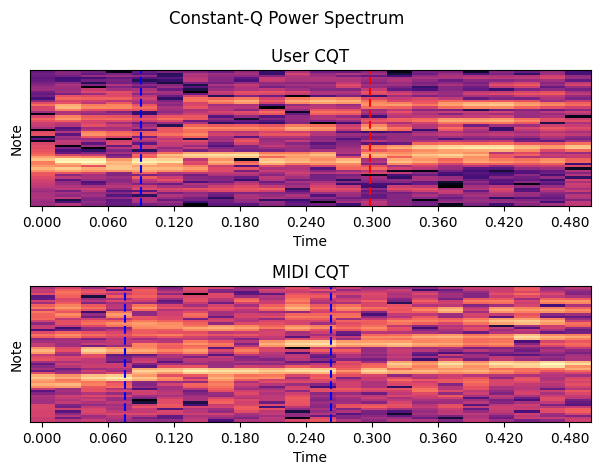

In [43]:
import librosa
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
user_img = librosa.display.specshow(user_cqt_slice, sr=SAMPLE_RATE, x_axis='time', 
                               y_axis='cqt_note', hop_length=CQT.HOP_LENGTH, ax=axs[0])

midi_img = librosa.display.specshow(midi_cqt_slice, sr=SAMPLE_RATE, x_axis='time', 
                               y_axis='cqt_note', hop_length=CQT.HOP_LENGTH, ax=axs[1])

axs[0].axvline(ideal_warped_user_onset_time, color='blue', linestyle='--', label='User Onset')
axs[0].axvline(actual_warped_user_onset_time, color='red', linestyle='--', label='User Onset')
axs[1].axvline(midi_onset_time, color='blue', linestyle='--', label='MIDI Onset')
axs[1].axvline(next_midi_onset_time, color='blue', linestyle='--', label='MIDI Onset')

fig.suptitle('Constant-Q Power Spectrum')
axs[0].set_title("User CQT")
axs[1].set_title("MIDI CQT")

plt.tight_layout()
plt.show()

In [47]:
from app.algorithms.align.CQT import CQT
import numpy as np

# take from 2 - 2.5 seconds in user audio
START_TIME = 2.0897958278656006
END_TIME = START_TIME + 0.5
start_idx = int(START_TIME * SAMPLE_RATE)
end_idx = int(END_TIME * SAMPLE_RATE)

# subtract start time to scale for the plotting
ideal_warped_user_onset_time = 0
actual_warped_user_onset_time = 2.2987754344940186 - START_TIME

user_audio_slice = audio_data.data[start_idx:end_idx]

# take from 1.8 - 2.3 seconds in midi
START_TIME = 1.8750050000000005
END_TIME = START_TIME + 0.5
start_idx = int(START_TIME * SAMPLE_RATE)
end_idx = int(END_TIME * SAMPLE_RATE)

midi_onset_time = 0
next_midi_onset_time = 2.0625055000000003 - START_TIME

midi_audio_slice = midi_audio.data[start_idx:end_idx]

# get the CQT of both as we compute in the app
user_cqt_slice = CQT.extract_cqt(user_audio_slice, sample_rate=SAMPLE_RATE)
midi_cqt_slice = CQT.extract_cqt(midi_audio_slice, sample_rate=SAMPLE_RATE)


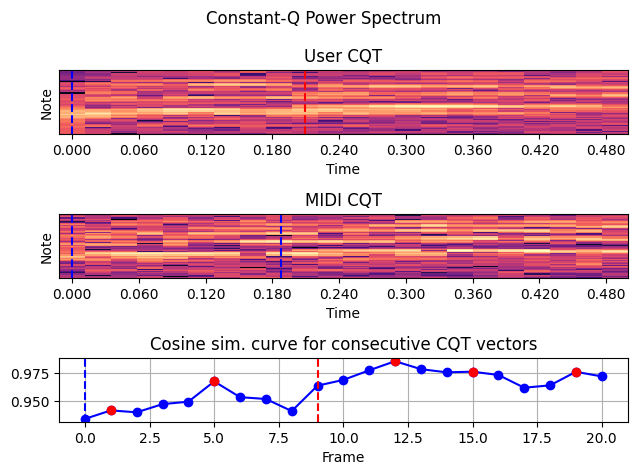

In [80]:
import librosa
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
user_img = librosa.display.specshow(user_cqt_slice, sr=SAMPLE_RATE, x_axis='time', 
                               y_axis='cqt_note', hop_length=CQT.HOP_LENGTH, ax=axs[0])

midi_img = librosa.display.specshow(midi_cqt_slice, sr=SAMPLE_RATE, x_axis='time', 
                               y_axis='cqt_note', hop_length=CQT.HOP_LENGTH, ax=axs[1])

axs[0].axvline(ideal_warped_user_onset_time, color='blue', linestyle='--', label='User Onset')
axs[0].axvline(actual_warped_user_onset_time, color='red', linestyle='--', label='User Onset')
axs[1].axvline(midi_onset_time, color='blue', linestyle='--', label='MIDI Onset')
axs[1].axvline(next_midi_onset_time, color='blue', linestyle='--', label='MIDI Onset')

fig.suptitle('Constant-Q Power Spectrum')
axs[0].set_title("User CQT")
axs[1].set_title("MIDI CQT")

axs[2].plot(cosine_similarities, marker='o', linestyle='-', color='b')
axs[2].plot(peaks, peak_values, 'ro', label='peaks')
axs[2].axvline(int((ideal_warped_user_onset_time*SAMPLE_RATE)/CQT.HOP_LENGTH), color='blue', linestyle='--', label='User Onset')
axs[2].axvline(int((actual_warped_user_onset_time*SAMPLE_RATE)/CQT.HOP_LENGTH), color='red', linestyle='--', label='User Onset')
axs[2].set_title('Cosine sim. curve for consecutive CQT vectors')
axs[2].set_xlabel('Frame')
axs[2].grid(True)

plt.tight_layout()
plt.show()

9

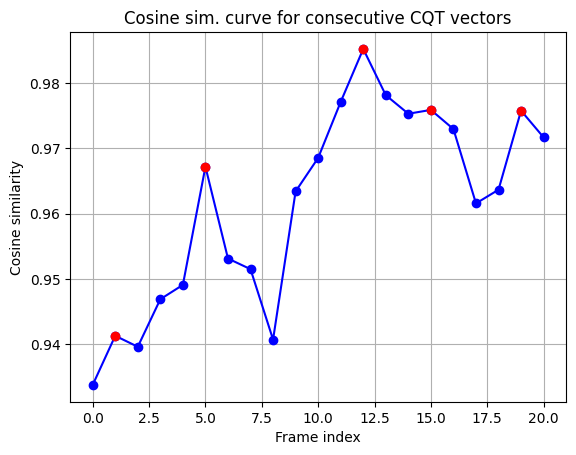

In [77]:
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.signal import find_peaks

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

n_vectors, n_frames = np.shape(user_cqt_slice)
cosine_similarities = []

for i in range(n_frames-1):
    vec1 = user_cqt_slice[:, i]
    vec2 = user_cqt_slice[:, i+1]
    sim = cosine_similarity(vec1, vec2)
    cosine_similarities.append(sim)

cosine_similarities = np.array(cosine_similarities)

peaks, _ = find_peaks(cosine_similarities)
first_peak_idx, first_peak_value = None, None

if len(peaks) > 0:
    first_peak_idx = peaks[0]
    first_peak_value = cosine_similarities[first_peak_idx]

peak_values = cosine_similarities[peaks]

# plot
plt.plot(cosine_similarities, marker='o', linestyle='-', color='b')
plt.plot(peaks, peak_values, 'ro', label='peaks')
plt.plot()
plt.title('Cosine sim. curve for consecutive CQT vectors')
plt.xlabel('Frame index')
plt.ylabel('Cosine similarity')
plt.grid(True)
plt.show()

## Listening to the slices
The CQT's look similar, but maybe we can listen to see if the difference in frequency bin expression is heard in the audio?

In [51]:
# Create audio data object for user slice
user_slice_data = AudioData()
user_slice_data.write_data(user_audio_slice)
# Create audio data object for midi slice
midi_slice_data = AudioData()
midi_slice_data.write_data(midi_audio_slice)

audio_player = AudioPlayer()
# audio_player.load_audio_data(user_slice_data)
audio_player.load_audio_data(midi_slice_data)
audio_player.play()

## Preliminary time matching
So the midi audio and user audio are at least corresponding to the same length of time, to hopefully improve the warping.

But does the timing really affect the warping? I thought not, since it's just two sequences?...

In [8]:
import numpy as np

def levenshtein_distance(user_notes, midi_notes):
    # Initialize the DP matrix
    dp = np.zeros((len(user_notes) + 1, len(midi_notes) + 1))
    
    # Fill the base cases
    for i in range(len(user_notes) + 1):
        dp[i][0] = i  # Cost of deletions
    for j in range(len(midi_notes) + 1):
        dp[0][j] = j  # Cost of insertions

    # Compute the DP table
    for i in range(1, len(user_notes) + 1):
        for j in range(1, len(midi_notes) + 1):
            # Define the cost of substitution based on note similarity
            if user_notes[i-1] == midi_notes[j-1]:  # Matching notes
                cost = 0
            else:
                cost = 1  # Mismatch cost for non-identical notes

            dp[i][j] = min(
                dp[i-1][j] + 1,       # Deletion
                dp[i][j-1] + 1,       # Insertion
                dp[i-1][j-1] + cost   # Substitution
            )

    # Backtrace to find alignment
    i, j = len(user_notes), len(midi_notes)
    alignment = []

    while i > 0 and j > 0:
        if user_notes[i-1] == midi_notes[j-1]:
            alignment.append((user_notes[i-1], midi_notes[j-1]))  # Match
            i -= 1
            j -= 1
        elif dp[i][j] == dp[i-1][j-1] + 1:  # Substitution
            alignment.append((user_notes[i-1], midi_notes[j-1]))
            i -= 1
            j -= 1
        elif dp[i][j] == dp[i-1][j] + 1:  # Deletion
            alignment.append((user_notes[i-1], None))
            i -= 1
        elif dp[i][j] == dp[i][j-1] + 1:  # Insertion
            alignment.append((None, midi_notes[j-1]))
            j -= 1

    # Add any remaining notes
    while i > 0:
        alignment.append((user_notes[i-1], None))
        i -= 1
    while j > 0:
        alignment.append((None, midi_notes[j-1]))
        j -= 1

    alignment.reverse()
    return dp[-1][-1], alignment

# Example usage
user_notes = [("C4", 1.0), ("D4", 1.0), ("E4", 1.5)]
midi_notes = [("C4", 1.0), ("E4", 1.5), ("F4", 1.0)]
distance, alignment = levenshtein_distance(user_notes, midi_notes)

print("Edit Distance:", distance)
print("Alignment:")
for u_note, m_note in alignment:
    print(f"User Note: {u_note} <-> MIDI Note: {m_note}")

Edit Distance: 2.0
Alignment:
User Note: ('C4', 1.0) <-> MIDI Note: ('C4', 1.0)
User Note: ('D4', 1.0) <-> MIDI Note: ('E4', 1.5)
User Note: ('E4', 1.5) <-> MIDI Note: ('F4', 1.0)


## Step 1: Filter onsets with total CQT alignment

In [ ]:
AUDIO_FILEPATH = '../../app/resources/audio/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0
SAMPLE_RATE = 44100

audio_data = AudioData()
audio_data.load_data(AUDIO_FILEPATH)
pitches, most_likely_pitches = PYin.pyin(audio_data.data)